In [1]:
import pandas as pd, numpy as np
from Bio import SeqIO
from itertools import product
from tqdm.notebook import tqdm
from function import clean

In [2]:
# nas_path = "./dataset/"
# lineage_label = np.array(pd.read_csv(os.path.join(nas_path, './1404_lineage_report and metadata 20220316.csv'))[['lineage_x','diff']])
# label_ = []
# new_lineage_label = []
# for idx, rna in enumerate(SeqIO.parse(os.path.join(nas_path, './1404.sequences.aln.fasta') ,"fasta")):
#     if "B.1.617.2" == lineage_label[idx][0]:
#     # break
#     # print(lineage_label[idx][0].split(' ')[0])
#         label_.append(lineage_label[idx][1].split(' ')[0])

#         new_lineage_label.append(str(rna.seq))
# print('sample:', len(new_lineage_label))
# class_,_ ,_,_= np.unique(label_,return_counts=True,return_index=True,return_inverse=True)
# print(class_)

In [3]:
# dict_search = {}
# for idx, i in enumerate('-NACGT'):

#     dict_search[i] = idx
# print(dict_search)
# from tqdm.notebook import tqdm
# num_new_sequences =[]
# for k in tqdm(new_lineage_label):
# 	temp_store=[]
# 	for j in k:
# 		# temp_store.append(clean(j)) #one hot
# 		temp_store.append(dict_search[clean(j)])
# 	num_new_sequences.append(temp_store)
# total_sequence_array = np.array(num_new_sequences)
# print(total_sequence_array.shape)

In [4]:
# from function import LogScaler
# ln = LogScaler()
# X_train_norm = ln.fit_transform(total_sequence_array)

In [5]:
# del new_lineage_label, num_new_sequences
# new_lineage_label = total_sequence_array
# one_hot_search_dict = {'C': [1,0,0,0,0,0], 'G': [0,1,0,0,0,0], 'A': [0,0,1,0,0,0],  'T': [0,0,0,1,0,0], 'N': [0,0,0,0,1,0],  '-': [0,0,0,0,0,1]}

# num_new_sequences =[]
# for k in tqdm(new_lineage_label):
# 	temp_single_seq_transfer = []
# 	for j in k:
# 		temp_single_seq_transfer+=one_hot_search_dict[j]
# 	num_new_sequences.append(temp_single_seq_transfer)
# total_sequence_array = np.array(num_new_sequences)
# print(total_sequence_array.shape)


In [6]:
# class_dict_ = {}
# for idx, i in enumerate(class_):
#     class_dict_[i] = idx
# print(class_dict_)
# multi_label = []
# for i in label_:
#     multi_label.append(class_dict_[i])

In [7]:
# np.save("gene.npy" ,total_sequence_array)
# np.save("label.npy" ,multi_label)
total_sequence_array = np.load('./gene.npy')
multi_label = np.load("./label.npy")

In [8]:
# from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
#onehot
X_train, X_test, y_train, y_test = train_test_split(total_sequence_array, multi_label,stratify = multi_label, test_size=0.25, random_state=42) 
# non onehot
# X_train, X_test, y_train, y_test = train_test_split(X_train_norm, multi_label,stratify = multi_label, test_size=0.25, random_state=42)

In [9]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class TransferDataset(Dataset):
    def __init__(self, s_path, labels):
        self.s_path = s_path
        self.labels = labels
        
    def __len__(self):
        return len(self.s_path)

    def __getitem__(self, idx):
        singel_image_ = self.s_path[idx].astype(np.float32)
        # print(singel_image_.shape)
        seed = np.random.randint(1e9)       
        random.seed(seed)
        np.random.seed(seed)
        singel_image_ = torch.FloatTensor(singel_image_)
        label = int(self.labels[idx])
        # print(label)

        return singel_image_, label

In [10]:
train_ds = TransferDataset(s_path= X_train, labels= y_train)
test_ds = TransferDataset(s_path= X_test, labels= y_test)
print(len(train_ds), len(test_ds))

851 284


In [11]:
import model_mlp
# from model_mlp import MLP
from model_mlp_seq import MLP
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP(2, X_train.shape[1]).to(device)
# model.initialize_weights()

In [18]:
import copy
from tqdm import tqdm_notebook
from sklearn import metrics
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0

    len_data = len(dataset_dl)
    for xb, yb in (dataset_dl):
    # for xb, yb in (dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        # print(type(xb), type(yb.shape))
        # output=torch.squeeze(torch.sigmoid(model(xb)))
        output=torch.squeeze(model(xb))
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b
        
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def metrics_batch(output, target):
    # print(target)
    # print(torch.argmax(output, dim=1))
    acc = metrics.accuracy_score(target.cpu().detach().numpy(), torch.argmax(output, dim=1).cpu().detach().numpy()>0.5)
    return acc


def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
 
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        

        print("train loss: %.6f, dev loss: %.6f,  train accuracy: %.2f,valid accuracy: %.2f" %(train_loss,val_loss, 100*train_metric,100*val_metric))
        print("-"*10) 
    model.load_state_dict(best_model_wts)
        
    return loss_history, metric_history

In [19]:
import model_mlp
from torch import optim
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
loss_func = nn.CrossEntropyLoss(reduction="sum")
# loss_func = nn.BCELoss(reduction='mean')
opt = optim.Adam(model.parameters(), lr=0.003)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)

In [20]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, 
                        shuffle=True)
test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                        shuffle=False)  
os.makedirs("./models", exist_ok=True)
# path2weights = "./models/weights_MLP_binaryclass(onehot).2022.05.24.pt"
path2weights = "./models/weights_MLP_binaryclass(onehot)-[model sequential class'0.1'] .2022.05.26.pth"
params_train={
    "num_epochs": 200,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2weights,
    }

loss_history, metric_history  = train_val(model, params_train)

Epoch 0/199, current lr=0.003
Copied best model weights!
train loss: 21.009518, dev loss: 50.468019,  train accuracy: 61.21,valid accuracy: 41.52
----------
Epoch 1/199, current lr=0.003
Copied best model weights!
train loss: 18.408672, dev loss: 41.351103,  train accuracy: 72.02,valid accuracy: 47.50
----------
Epoch 2/199, current lr=0.003
train loss: 15.726642, dev loss: 50.597941,  train accuracy: 81.75,valid accuracy: 41.65
----------
Epoch 3/199, current lr=0.003
train loss: 16.202225, dev loss: 49.335926,  train accuracy: 78.31,valid accuracy: 45.04
----------
Epoch 4/199, current lr=0.003
train loss: 13.736496, dev loss: 50.594074,  train accuracy: 88.33,valid accuracy: 43.39
----------
Epoch 5/199, current lr=0.003
train loss: 13.219997, dev loss: 52.041416,  train accuracy: 89.23,valid accuracy: 41.43
----------
Epoch 6/199, current lr=0.003
train loss: 13.628252, dev loss: 48.552215,  train accuracy: 87.50,valid accuracy: 43.93
----------
Epoch 7/199, current lr=0.003
Epoch 

Text(0.5, 1.0, 'loss history')

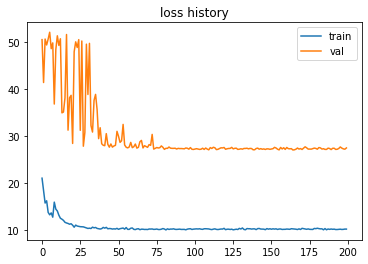

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_history['train'])
plt.plot(loss_history['val'])
plt.legend(['train','val'])
plt.title('loss history')

Text(0.5, 1.0, 'onehot accuracy history')

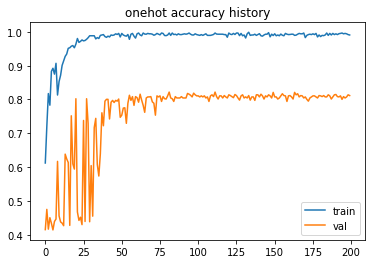

In [22]:
plt.plot(metric_history['train'])
plt.plot(metric_history['val'])
plt.legend(['train','val'])
plt.title('onehot accuracy history')